In [2]:
import numpy as np
import pandas as pd
from aisynphys.database import default_db as db
from aisynphys.cell_class import CellClass, classify_cells, classify_pairs
from aisynphys.connectivity import measure_connectivity, GaussianModel
from aisynphys.ui.notebook import show_connectivity_matrix, get_metric_data, pair_class_metric_scatter, metric_stats, show_connectivity_profile, compose_svg_figure
import matplotlib.colors, matplotlib.cm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
matplotlib.rcParams['font.sans-serif'] = "Arial"
print(db.schema_version)

21


In [3]:
projects = ['mouse V1 coarse matrix', 'mouse V1 pre-production']
mouse_pairs = db.pair_query(project_name=projects).all()
print("loaded %d cell pairs" % len(mouse_pairs))

loaded 83006 cell pairs


In [4]:
cell_class_criteria = {
    'l23pv':  {'cre_type': 'pvalb',            'cortical_layer': '2/3'},
    'l23sst': {'cre_type': 'sst',              'cortical_layer': '2/3'},
    'l23vip': {'cre_type': 'vip',              'cortical_layer': '2/3'},
    'l4pv':  {'cre_type': 'pvalb',            'cortical_layer': '4'},
    'l4sst': {'cre_type': 'sst',              'cortical_layer': '4'},
    'l4vip': {'cre_type': 'vip',              'cortical_layer': '4'},
    'l5pv':   {'cre_type': 'pvalb',            'cortical_layer': '5'},
    'l5sst':  {'cre_type': 'sst',              'cortical_layer': '5'},
    'l5vip':  {'cre_type': 'vip',              'cortical_layer': '5'},
    'l6pv':   {'cre_type': 'pvalb',            'cortical_layer': ('6', '6a', '6b')},
    'l6sst':  {'cre_type': 'sst',              'cortical_layer': ('6', '6a', '6b')},
    'l6vip':  {'cre_type': 'vip',              'cortical_layer': ('6', '6a', '6b')},
}

cell_classes = {name:CellClass(name=name, **criteria) for name,criteria in cell_class_criteria.items()}

In [5]:
# Group all cells by selected classes
cell_groups = classify_cells(cell_classes.values(), pairs=mouse_pairs, missing_attr='ignore')

# Group pairs into (pre_class, post_class) groups
pair_groups = classify_pairs(mouse_pairs, cell_groups)

# analyze matrix elements
connectivity_results = measure_connectivity(pair_groups, sigma=75e-6, fit_model=GaussianModel, dist_measure='lateral_distance')

In [5]:
def sigma_simulation(data, sigma_range, model=GaussianModel, n_trials=1000):
# data is a nested dictionary like:
# {'syn_type': {'fit': model_fit, 'distances': numpy distance array}, 'syn_type': {}...}

    results = {}
    for sigma in sigma_range:

        results[sigma] = {syn_type: [] for syn_type in data.keys()}
        for syn_type, values in data.items():
            pmax = values['fit'].pmax
            distances = values['distances']
            true_model = model(pmax=pmax, size=sigma)
            for n in range(n_trials):
                conn = true_model.generate(distances)
                fit = model.fit(distances, conn, method='L-BFGS-B')
                results[sigma][syn_type].append(fit)
    
    return results

def check_pair_inhib(p, syn_type):
    # must have been probed for connectivity
    if syn_type=='chemical':
        return( 
            pair_was_probed(p, 'in') and
            # must have a true/false connection call
            p.has_synapse is not None and
            # intersomatic distance < 500 µm (removes some bad data with very large distances)
            p.lateral_distance is not None and 
            p.lateral_distance < 500e-6
        )
    # must have been probed for connectivity
    if syn_type=='electrical':
        return(
            pair_probed_gj(p) and
            # must have a true/false connection call
            p.has_electrical is not None and
            # intersomatic distance < 500 µm (removes some bad data with very large distances)
            p.lateral_distance is not None and 
            p.lateral_distance < 500e-6
        )

In [7]:
from aisynphys.connectivity import pair_probed_gj, pair_was_probed


inhib = CellClass(cell_class_nonsynaptic='in', name='inhib')
i_pairs = db.pair_query(pre_class=inhib, post_class=inhib, project_name=projects).all()
i_probed = [p for p in i_pairs if check_pair_inhib(p, 'electrical')]
probed_syn = [p for p in i_pairs if check_pair_inhib(p, 'chemical')]

dist = np.array([p.lateral_distance for p in i_probed], dtype=float)
gaps = np.array([p.has_electrical for p in i_probed], dtype=bool)

mask_gap = np.isfinite(dist) & np.isfinite(gaps)

method = 'L-BFGS-B'
gap_fit = GaussianModel.fit(dist[mask_gap], gaps[mask_gap], method=method)


syn_dist = np.array([p.lateral_distance for p in probed_syn], dtype=float)
syn = np.array([p.has_synapse for p in probed_syn], dtype=bool)
mask_syn = np.isfinite(syn_dist) & np.isfinite(syn)
syn_fit = GaussianModel.fit(syn_dist[mask_syn], syn[mask_syn], method=method)



measured_sigma_ratio = syn_fit.size / gap_fit.size
sigma_range = np.linspace(65e-6, 140e-6, 6)
data = {
    'electrical': {'fit': gap_fit, 'distances': dist}, 
    'chemical': {'fit': syn_fit, 'distances': syn_dist}
}
sigma_results = sigma_simulation(data, sigma_range, n_trials=1000)


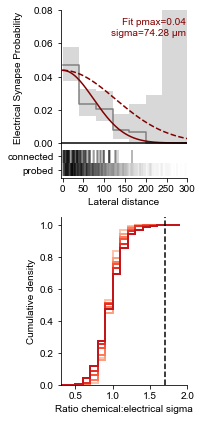

In [8]:
import scipy.stats as stats

S4B, ax = plt.subplots(2, 1, figsize=(3,6))
ymax=0.08
tickheight = ymax / 10
show_connectivity_profile(dist[mask_gap], gaps[mask_gap], ax[0], gap_fit, ymax=0.08)
y_vals = np.arange(0, ymax + 0.1, 0.02)
ax[0].set_yticks([-tickheight*2, -tickheight] + list(y_vals))
ax[0].set_yticklabels(['probed', 'connected'] + ['%0.2f'%x for x in y_vals])
ax[0].set_ylim(-tickheight*2.6, ymax)

label = ("Fit pmax=%0.2f\nsigma=%0.2f µm" % (gap_fit.pmax, gap_fit.size*1e6))
ax[0].text(0.99, 0.85, label, transform=ax[0].transAxes, color=(0.5, 0, 0), horizontalalignment='right', fontsize=10)
ax[0].set_xlim(-5e-6, 300e-6) 
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].yaxis.set_label_coords(-0.3, 0.6)
    
ax[0].set_xlabel('Lateral distance')
ax[0].set_ylabel('Electrical Synapse Probability')

x_bins = np.arange(0, 500e-6, 40e-6)
x_vals = np.linspace(x_bins[0], x_bins[-1], 200)
syn_fit.pmax = gap_fit.pmax
ax[0].plot(x_vals, syn_fit.connection_probability(x_vals), color=(0.5, 0, 0), ls='--')

colors = sns.color_palette('Reds', n_colors=8)
bins = np.arange(0, 2, 0.1)

percentiles = []
for i, (sigma, result) in enumerate(sigma_results.items()):
    chem_size = np.array([fit.size for fit in result['chemical']])
    gap_size = np.array([fit.size for fit in result['electrical']])
    sigma_ratio = chem_size / gap_size
    sigma_diff = abs(chem_size - gap_size)
    percentiles.append(stats.percentileofscore(sigma_ratio, measured_sigma_ratio))
    n, bins, patches = ax[1].hist(sigma_ratio, histtype='step', bins=bins, cumulative=True, density=True, color=colors[i+1], lw=2, 
                               label='%d µm' % (sigma*1e6))
    patches[0].set_xy(patches[0].get_xy()[:-1])

ax[1].axvline(measured_sigma_ratio, color='k', ls='--', label='Measured ratio')
# ax[1].legend()

ax[1].set_xlim(0.3, 2)
ax[1].set_ylabel('Cumulative density')
ax[1].set_xlabel('Ratio chemical:electrical sigma')
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)

plt.tight_layout()

In [ ]:
measured_sigma_ratio

Text(0.5, 0, 'Electrical Synapse Probability')

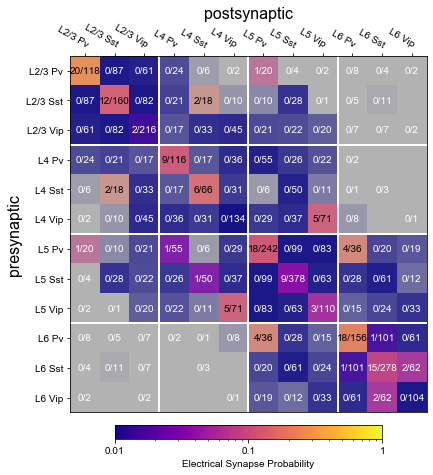

In [6]:
# define a colormap and log normalization used to color the heatmap
norm = matplotlib.colors.LogNorm(vmin=0.01, vmax=1.0, clip=True)
cmap = matplotlib.cm.get_cmap('plasma')

# define the display labels to use for each cell subclass:
class_labels = {
    'l23pv':  'L2/3 Pv',
    'l23sst': 'L2/3 Sst',
    'l23vip': 'L2/3 Vip',
    'l4pv':   'L4 Pv',
    'l4sst':  'L4 Sst',
    'l4vip':  'L4 Vip',
    'l5pv':   'L5 Pv',
    'l5sst':  'L5 Sst',
    'l5vip':  'L5 Vip',
    'l6pv':   'L6 Pv',
    'l6sst':  'L6 Sst',
    'l6vip':  'L6 Vip',
}

# create a figure/axes to draw on
S4A, ax = plt.subplots(figsize=(8, 8))

# finally, draw the colormap using the provided function:
im, cbar, labels = show_connectivity_matrix(
    ax=ax, 
    results=connectivity_results, 
    pre_cell_classes=cell_classes.values(), 
    post_cell_classes=cell_classes.values(), 
    class_labels=class_labels, 
    ctype='electrical',
    distance_adjusted=True,
    cbarlabel='Gap junction probability',
    cmap=cmap, 
    norm=norm, 
    layer_lines=[2.5, 5.5, 8.5]
)

cbar.remove()
cbar = S4A.colorbar(im, ax=ax, orientation='horizontal', shrink=0.6, pad=0.03)
cbar.ax.set_xticklabels(['0.01', '0.1', '1'], fontsize=10)
cbar.ax.set_xlabel('Electrical Synapse Probability')

In [14]:
vip = {'gaps':0, 'gaps_probed': 0}
pv = {'gaps':0, 'gaps_probed': 0}

for pair_class, results in connectivity_results.items():
    pre_class, post_class = pair_class
    if 'pv' in pre_class.name and 'pv' in post_class.name:
        pv['gaps'] += results['n_gaps']
        pv['gaps_probed'] += results['n_gaps_probed']
    if 'vip' in pre_class.name and 'vip' in post_class.name:
        vip['gaps'] += results['n_gaps']
        vip['gaps_probed'] += results['n_gaps_probed']

print(pv)
print(vip)

from scipy.stats import chi2_contingency
pv_unconnected = pv['gaps_probed'] - pv['gaps']
vip_unconnected = vip['gaps_probed'] - vip['gaps']

chi2, p, dof, expected = chi2_contingency(np.array([[pv['gaps'], pv_unconnected], [vip['gaps'], vip_unconnected]]))
print(chi2, p)

{'gaps': 76, 'gaps_probed': 922}
{'gaps': 15, 'gaps_probed': 908}
40.672507421490415 1.8000194306004935e-10


In [6]:
fname = 'C:\\Users\\stephanies\\aisynphys\\analyses\\figures\\gap_matrix.svg'
gap_fig.savefig(fname, bbox_inches='tight')

In [3]:
subclass_criteria = {
    'pv':     {'cre_type': 'pvalb'},
    'sst':    {'cre_type': 'sst'},
    'vip':    {'cre_type': 'vip'},  
}

cell_classes2 = {name:CellClass(name=name, **criteria) for name,criteria in subclass_criteria.items()}

pair_classes = [
    ('pv', 'pv'),
    ('sst', 'sst'),
    ('vip', 'vip'),
]

pair_classes = [(cell_classes2[pre], cell_classes2[post]) for pre, post in pair_classes]

metrics = [
    ('gap_junction.coupling_coeff_pulse', 'Coupling Coefficient'),
    ('gap_junction.junctional_conductance', 'Junctional\nConductance (nS)')
]

pair_query_args = {
    'project_name': projects,
    'electrical': True,
}

plot_args = {'alpha': 0.7, 'edgecolor': 'w'}

colors = sns.color_palette('muted', n_colors=len(pair_classes))

In [4]:
gap_pairs = None
for pre_name, pre_class in cell_classes2.items():
    for post_name, post_class in cell_classes2.items():
        pair_query = db.pair_query(
            pre_class=pre_class,
            post_class=post_class,
            **pair_query_args
        )

        pair_query = pair_query.outerjoin(db.Intrinsic, db.Intrinsic.cell_id==db.Pair.post_cell_id)
        pair_query = pair_query.outerjoin(db.GapJunction, db.GapJunction.pair_id==db.Pair.id)
        pair_query = pair_query.add_columns(db.GapJunction.junctional_conductance, 
                                            db.Intrinsic.input_resistance_ss, 
                                            db.GapJunction.coupling_coeff_pulse)

        df = pair_query.dataframe()
        df['pre_class'] = pre_name
        df['post_class'] = post_name
        df['pair_class'] = '%s→%s' % (pre_class, post_class)
        if gap_pairs is None:
            gap_pairs = df
        else:
            gap_pairs = gap_pairs.append(df)
gap_pairs['gap_junction.junctional_conductance'] *= 1e9
gap_pairs['intrinsic.input_resistance_ss'] *= 1e-6
print(len(gap_pairs))
# print(gap_pairs.dtypes)
gap_pairs.head()

170


,pair.id,pair.experiment_id,pair.pre_cell_id,pair.post_cell_id,pair.has_synapse,pair.has_polysynapse,pair.has_electrical,pair.crosstalk_artifact,pair.n_ex_test_spikes,pair.n_in_test_spikes,...,pair.lateral_distance,pair.vertical_distance,pair.reciprocal_id,pair.meta,gap_junction.junctional_conductance,intrinsic.input_resistance_ss,gap_junction.coupling_coeff_pulse,pre_class,post_class,pair_class
0,64391,1945,11362,11363,False,False,True,NaN,660,540,...,0.000012,0.000057,64398,None,0.407847,191.167136,0.072095,pv,pv,pv→pv
1,64996,1965,11477,11484,True,False,True,NaN,87,87,...,0.000010,0.000034,65070,None,NaN,NaN,NaN,pv,pv,pv→pv
2,65070,1965,11484,11477,False,False,True,NaN,84,0,...,0.000010,0.000034,64996,None,NaN,74.137277,NaN,pv,pv,pv→pv
3,92318,2951,16730,16735,False,False,True,NaN,574,514,...,0.000010,0.000001,92344,None,-0.002168,173.701792,-0.000388,pv,pv,pv→pv
4,92344,2951,16735,16730,True,False,True,NaN,574,514,...,0.000010,0.000001,92318,None,0.125176,113.883224,0.014235,pv,pv,pv→pv


In [28]:
bidirectional = gap_pairs[gap_pairs['pair.id'].isin(gap_pairs['pair.reciprocal_id'].to_list())]
bidirectional.groupby('pair_class').count()

,pair.id,pair.experiment_id,pair.pre_cell_id,pair.post_cell_id,pair.has_synapse,pair.has_polysynapse,pair.has_electrical,pair.crosstalk_artifact,pair.n_ex_test_spikes,pair.n_in_test_spikes,pair.distance,pair.lateral_distance,pair.vertical_distance,pair.reciprocal_id,pair.meta,gap_junction.junctional_conductance,intrinsic.input_resistance_ss,gap_junction.coupling_coeff_pulse,pre_class,post_class
pair_class,,,,,,,,,,,,,,,,,,,,
pv→pv,74,74,74,74,74,74,74,0,74,74,74,74,74,74,0,64,67,66,74,74
pv→sst,1,1,1,1,1,1,1,0,1,1,1,1,1,1,0,1,1,1,1,1
sst→pv,1,1,1,1,1,1,1,0,1,1,1,1,1,1,0,1,1,1,1,1
sst→sst,48,48,48,48,48,48,48,0,48,48,48,40,40,48,0,42,44,42,48,48
sst→vip,2,2,2,2,2,2,2,0,2,2,2,2,2,2,0,2,2,2,2,2
vip→sst,2,2,2,2,2,2,2,0,2,2,2,2,2,2,0,2,2,2,2,2
vip→vip,20,20,20,20,20,20,20,0,20,20,20,20,20,20,0,12,13,14,20,20


(-0.30716911998569746, 2)

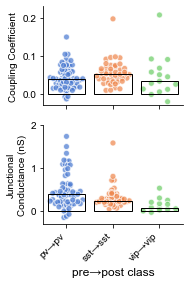

In [19]:
from aisynphys.ui.notebook import swarm
order = ['pv→pv', 'sst→sst', 'vip→vip']
S4C, ax = plt.subplots(len(metrics), 1, figsize=(2.5, 2 * len(metrics)))
# pair_class_metric_scatter(metrics, db, pair_classes, pair_query_args, ax, estimator=np.median, plot_args=plot_args)

for i, metric_opts in enumerate(metrics):
    metric, label = metric_opts
    metric_df = gap_pairs[(~gap_pairs[metric].isnull()) & (gap_pairs['pair_class'].isin(order))]
    groups = metric_df.groupby('pair_class')
    y_vals = [groups.get_group(pair_class)[metric].to_list() for pair_class in order]
    x_vals = swarm(y_vals)
    c2 = [[c]*len(y_vals[i]) for i, c in enumerate(colors)]
    ax[i].scatter(np.concatenate(x_vals), np.concatenate(y_vals), color=np.concatenate(c2), **plot_args)
    plot = sns.barplot(x='pair_class', y=metric, data=metric_df, ax=ax[i], ci=None, facecolor=(1, 1, 1, 0), edgecolor='black', 
                order=order, estimator=np.median)
    if i==len(metrics) - 1:
        ax[i].set_xlabel('pre→post class', size=12)
        ax[i].set_xticklabels(plot.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize='medium')
    else:
        ax[i].set_xlabel('')
        ax[i].set_xticklabels('')
    ax[i].set_ylabel(label)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    
ax[0].set_ylim(-0.03, 0.23)
ax[1].set_ylim(None, 2)

In [7]:
from scipy.stats import mannwhitneyu

pv_jc = gap_pairs[(~gap_pairs['gap_junction.junctional_conductance'].isnull()) & (gap_pairs['pair_class']=='pv→pv')]['gap_junction.junctional_conductance'].to_numpy()
sst_jc = gap_pairs[(~gap_pairs['gap_junction.junctional_conductance'].isnull()) & (gap_pairs['pair_class']=='sst→sst')]['gap_junction.junctional_conductance'].to_numpy()
vip_jc = gap_pairs[(~gap_pairs['gap_junction.junctional_conductance'].isnull()) & (gap_pairs['pair_class']=='vip→vip')]['gap_junction.junctional_conductance'].to_numpy()

_, pv_sst = mannwhitneyu(pv_jc, sst_jc, alternative='two-sided')
print(pv_sst)
_, pv_vip = mannwhitneyu(pv_jc, vip_jc, alternative='two-sided')
print(pv_vip)

0.017367379470259972
0.0005040188635393852


In [12]:
gap_pairs.groupby('pair_class').describe()['gap_junction.coupling_coeff_pulse']

,count,mean,std,min,25%,50%,75%,max
pair_class,,,,,,,,
pv→pv,71.0,0.040893,0.031593,-0.040110,0.018085,0.037533,0.060167,0.149240
pv→sst,1.0,0.167299,NaN,0.167299,0.167299,0.167299,0.167299,0.167299
sst→pv,1.0,0.108183,NaN,0.108183,0.108183,0.108183,0.108183,0.108183
sst→sst,47.0,0.054321,0.030790,0.008910,0.037843,0.051761,0.066205,0.197042
sst→vip,2.0,0.005190,0.040504,-0.023450,-0.009130,0.005190,0.019511,0.033831
vip→sst,2.0,-0.003553,0.012259,-0.012222,-0.007888,-0.003553,0.000781,0.005115
vip→vip,15.0,0.046655,0.054992,-0.020890,0.012038,0.033083,0.062184,0.207253


In [13]:
print('Units: %s' % 'nS')
gap_pairs.groupby('pair_class').describe()['gap_junction.junctional_conductance']

Units: nS


,count,mean,std,min,25%,50%,75%,max
pair_class,,,,,,,,
pv→pv,69.0,0.487642,0.443225,-0.161396,0.203169,0.381945,0.616291,2.086290
pv→sst,1.0,0.742495,NaN,0.742495,0.742495,0.742495,0.742495,0.742495
sst→pv,1.0,0.571390,NaN,0.571390,0.571390,0.571390,0.571390,0.571390
sst→sst,47.0,0.305783,0.248931,0.039621,0.194960,0.230214,0.356791,1.578386
sst→vip,2.0,0.010826,0.088572,-0.051804,-0.020489,0.010826,0.042141,0.073456
vip→sst,2.0,-0.012970,0.063222,-0.057675,-0.035322,-0.012970,0.009382,0.031735
vip→vip,13.0,0.132588,0.155054,-0.040505,0.027694,0.070377,0.194457,0.523749


Text(0, 0.5, 'Junctional conductance (nS)')

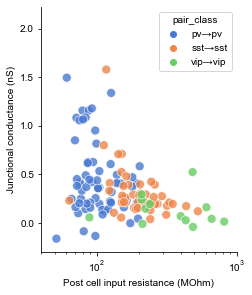

In [14]:
S4D, ax = plt.subplots(figsize=(3.5, 4.5))
order = ['pv→pv', 'sst→sst', 'vip→vip']
pairs_copy = gap_pairs.copy()
pairs_copy = pairs_copy[pairs_copy['pair_class'].isin(order)]
plot = sns.scatterplot(y='gap_junction.junctional_conductance', x='intrinsic.input_resistance_ss', data=pairs_copy,
                       s=80, hue='pair_class', ax=ax, palette='muted', alpha=0.8, hue_order=order)
# sns.barplot(x='pair_class', y='input_resistance', data=pairs_has_metric, ax=ax, ci=None, facecolor=(1, 1, 1, 0), edgecolor='black')
ax.set_xscale('log')
ax.set_xlim(4e1, 1e3)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Post cell input resistance (MOhm)')
ax.set_ylabel('Junctional conductance (nS)')

In [15]:
order = ['pv→pv', 'sst→sst', 'vip→vip']
# pairs_copy2 = pairs.copy()
# pairs_copy2.astype({'coupling_coeff_pulse': float, 'junctional_conductance': float})
# pairs_copy2['junctional_conductance']*=1e9
recip_gj = {}
for i, pair in gap_pairs.iterrows():
    if pair.pair_class not in order:
        continue
    recip_id = pair['pair.reciprocal_id']
    if recip_id in recip_gj.keys():
        continue
    recip_pair = db.query(db.Pair).filter(db.Pair.id==recip_id).all()[0]
    if recip_pair.gap_junction is None:
        continue
    if pair['gap_junction.coupling_coeff_pulse'] is None and pair['gap_junction.junctional_conductance'] is None:
        continue
    recip_gj[pair['pair.id']] = {}
    
    recip_gj[pair['pair.id']]['cc'] = pair['gap_junction.coupling_coeff_pulse']
    recip_gj[pair['pair.id']]['jc'] = pair['gap_junction.junctional_conductance']
    
    recip_cc = recip_pair.gap_junction.coupling_coeff_pulse
    recip_gj[pair['pair.id']]['recip_cc'] = recip_cc
    
    recip_jc =recip_pair.gap_junction.junctional_conductance 
    recip_gj[pair['pair.id']]['recip_jc'] = recip_jc * 1e9
    
    recip_gj[pair['pair.id']]['pair_class'] = pair['pair_class']
    db_pair = db.query(db.Pair).filter(db.Pair.id==pair['pair.id']).all()[0]
    recip_gj[pair['pair.id']]['expt_id'] = db_pair.experiment.ext_id

recip_df = pd.DataFrame.from_dict(recip_gj, orient='index')
recip_df.head()
# recip_df[(~recip_df['jc'].isnull()) & (~recip_df['recip_jc'].isnull())]


,cc,jc,recip_cc,recip_jc,pair_class,expt_id
64391,0.072095,0.407847,0.040227,NaN,pv→pv,1534538663.167
92318,-0.000388,-0.002168,0.014235,0.125176,pv→pv,1554840500.979
39280,0.060357,0.627141,0.021780,0.195984,pv→pv,1506986382.913
40369,0.027317,0.392046,-0.013703,-0.133094,pv→pv,1507762035.262
41612,0.068929,0.605483,0.076351,1.083074,pv→pv,1509138997.938


In [16]:
import scipy.stats as stats
cc = recip_df[(~recip_df['cc'].isna()) & (~recip_df['recip_cc'].isna())]
cc_m, cc_b, cc_r, cc_p, _ = stats.linregress(cc['cc'].to_numpy(dtype=float), cc['recip_cc'].to_numpy(dtype=float))
cc_pearson = stats.pearsonr(cc['cc'].to_numpy(dtype=float), cc['recip_cc'].to_numpy(dtype=float))
print(cc_pearson)
jc = recip_df[(~recip_df['jc'].isna()) & (~recip_df['recip_jc'].isna())]
jc_m, jc_b, jc_r, jc_p, _ = stats.linregress(jc['jc'].to_numpy(dtype=float), jc['recip_jc'].to_numpy(dtype=float))
jc_pearson = stats.pearsonr(jc['jc'].to_numpy(dtype=float), jc['recip_jc'].to_numpy(dtype=float))
print(jc_pearson)

(0.46336547056317445, 4.151242936573412e-05)
(0.7403679987274038, 3.591410285428078e-13)


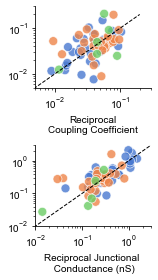

In [17]:
recip, axs = plt.subplots(2, 1, figsize=(2.3,4))
order = ['pv→pv', 'sst→sst', 'vip→vip']
sns.scatterplot(x='recip_cc', y='cc', data=recip_df, hue='pair_class', ax=axs[0], palette='muted', alpha=0.8, legend=False, s=80,
               hue_order=order)
axs[0].plot([-0.05, 0.2], [-0.05, 0.2], lw=1, ls='--', color=(0, 0,0))
# sns.regplot(x='cc', y='recip_cc', data=recip_df, ax=axs[0], ci=95, robust=True, color='magenta', scatter_kws=dict(s=0))
axs[0].set_ylabel('')
axs[0].set_xlabel('Reciprocal\nCoupling Coefficient')
axs[0].set_xlim(0.005, 0.3)
axs[0].set_ylim(0.005, 0.3)

sns.scatterplot(x='recip_jc', y='jc', data=recip_df, hue='pair_class', ax=axs[1], palette='muted', alpha=0.8, legend=False, s=80,
               hue_order=order)
axs[1].plot([-0.05, 5], [-0.05, 5], lw=1, ls='--', color=(0, 0,0))
# sns.regplot(x='jc', y='recip_jc', data=recip_df, ax=axs[1], ci=95, robust=True, color='magenta', scatter_kws=dict(s=0))
axs[1].set_ylabel('')
axs[1].set_xlabel('Reciprocal Junctional \n Conductance (nS)')
axs[1].set_xlim(0.01, 3)
axs[1].set_ylim(0.01, 3)

for ax in axs:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_yscale('log')
    ax.set_xscale('log')
    
plt.tight_layout()

In [30]:
import os
label_opts = {'size': '16pt', 'font': 'arial', 'weight': 'bold'}

figure_spec = [
    {'figure': S4A, 'pos': (0, 20), 'label': 'A', 'label_opts': label_opts},
    {'figure': S4B, 'pos': (430, 30), 'label': 'B', 'label_opts': label_opts},
    {'figure': S4C, 'pos': (0, 500), 'label': 'C', 'label_opts': label_opts},
    {'figure': recip, 'pos': (200, 500), 'label': '', 'label_opts': label_opts},
    {'figure': S4D, 'pos': (380, 500), 'label': 'D', 'label_opts': label_opts},
]

compose_svg_figure(figure_spec, size=("7in", "9in"), filename=os.path.join('generated_svg', 'fig_S4.svg'), display=True)